In [1]:
# Modules
import numpy as np
import pandas as pd
import requests as req
from census import Census
from us import states
import json
import matplotlib.pyplot as plt
import scipy.stats

In [2]:
# Census API Key from class and target year for our data
c = Census('85ac64b6b5a9c0901b00329d1ef41f0c53ccfc98', year=2014)

# URL and seperated key for second census API call
url = 'http://api.census.gov/data/2014/pep/cty'
api_key = '85ac64b6b5a9c0901b00329d1ef41f0c53ccfc98'

In [3]:
# Make list of target locations using census format
locations = ['003', '510', '013', '550', '041', '059', '650', '087',
             '107', '700', '710', '153', '760', '177', '179', '810']

# Create empty list to store the returned data dictionaries from each location
census_data = []

In [4]:
# Loop API calls for each of the target locations
for loc in locations:
    loc_data = c.acs5.get(('NAME', 'B19013_001E', 'B01003_001E', 'B01002_001E'),
                             {'for': 'county :' + loc , 'in': 'state : 51'})
    
    # Append the consolidated data list with the individual location data
    census_data.append(loc_data)
    
print(census_data)   

[[{'NAME': 'Albemarle County, Virginia', 'B19013_001E': 67958.0, 'B01003_001E': 101883.0, 'B01002_001E': 38.5, 'state': '51', 'county': '003'}], [{'NAME': 'Alexandria city, Virginia', 'B19013_001E': 87319.0, 'B01003_001E': 146422.0, 'B01002_001E': 35.8, 'state': '51', 'county': '510'}], [{'NAME': 'Arlington County, Virginia', 'B19013_001E': 105120.0, 'B01003_001E': 220173.0, 'B01002_001E': 33.8, 'state': '51', 'county': '013'}], [{'NAME': 'Chesapeake city, Virginia', 'B19013_001E': 70176.0, 'B01003_001E': 228168.0, 'B01002_001E': 36.6, 'state': '51', 'county': '550'}], [{'NAME': 'Chesterfield County, Virginia', 'B19013_001E': 72514.0, 'B01003_001E': 324337.0, 'B01002_001E': 38.0, 'state': '51', 'county': '041'}], [{'NAME': 'Fairfax County, Virginia', 'B19013_001E': 112102.0, 'B01003_001E': 1117072.0, 'B01002_001E': 37.4, 'state': '51', 'county': '059'}], [{'NAME': 'Hampton city, Virginia', 'B19013_001E': 49879.0, 'B01003_001E': 136904.0, 'B01002_001E': 35.5, 'state': '51', 'county': '6

In [5]:
# use list comprehension to filter the list of lists which each contain one dict
new_list = [i[0] for i in census_data]

In [6]:
# Turn new list of dicts into data frame
census_data_df = pd.DataFrame.from_dict(new_list)

# Rename wierd census columns
census_data_df.rename(columns={'B01002_001E': 'Median Age', 'B01003_001E': 'Median Household Income',
                               'B19013_001E': 'Population', 'NAME': 'Locale'}, inplace=True)

# Drop redundent columns
census_data_df = census_data_df.drop(['county', 'state'], axis=1)

# Show df
#census_data_df

In [7]:
# Read crime csv data into df
crime_df = pd.read_csv('raw_data/FBI-crime-data_VA_2014.csv')

# Rename the local column
crime_df.rename(columns={'Crime Category': 'Locale'}, inplace=True)

# Drop extra columns
crime_df = crime_df.drop(['Murder and nonnegligent manslaughter', 'Rape', 'Robbery',
                          'Aggravated assault', 'Burglary', 'Larceny-theft',
                          'Motor vehicle theft'], axis=1)

# Show df
#crime_df

In [8]:
# Merge census and crime dfs on Local
census_crime_df = pd.merge(census_data_df, crime_df, how='outer', on='Locale')
#census_crime_df

In [9]:
census_crime_df.dtypes

Median Age                 float64
Median Household Income    float64
Population                 float64
Locale                      object
Violent crime total          int64
Property crime total         int64
dtype: object

In [10]:
census_crime_df['Violent Rate'] = census_crime_df['Violent crime total'] / census_crime_df['Population']

census_crime_df['Property Rate'] = census_crime_df['Property crime total'] / census_crime_df['Population']

#census_crime_df

In [11]:
# Read crime csv data into df
walk_df = pd.read_csv('walk and transit scores.csv')

# Drop extra columns
walk_df = walk_df.drop(['Unnamed: 0', 'transit score'], axis=1)

# Groupby local/area and avg the walk scores
walk_df_mean = walk_df.groupby('Area').mean()

# Show df
#walk_df_mean

In [12]:
walk_df_mean['Locale'] = list(census_crime_df['Locale'])

#walk_df_mean

In [13]:
ccb_df = pd.merge(census_crime_df, walk_df_mean, how='outer', on='Locale')

# Drop extra columns
ccb_df = ccb_df.drop(['lat', 'lon'], axis=1)

# Rename the local column
ccb_df.rename(columns={'Violent crime total':'Violent Crime Total', 'walk score':'Walk Score',
                         'Property crime total':'Property Crime Total'}, inplace=True)


#ccb_df

In [14]:
# Define target data from 2nd census API to include population density
td = 'DENSITY'
state = '51'
# date references the census Pop Density calculation for 2014; see api docs
date ='7'

# Create empty list for density data to be sotred by location
density_data = []

# Loop 2nd API calls for each of the target locations
for loc in locations:
    # setup paramas dict
    params = {'get' : td, 'for': 'county :' + loc , 'in': 'state : 51', 'DATE': date, 'key' : api_key}
    density = req.get(url, params).json()

    density_data.append(density)    
print(density_data)


[[['DENSITY', 'DATE', 'state', 'county'], ['144.96253365', '7', '51', '003']], [['DENSITY', 'DATE', 'state', 'county'], ['10005.381352', '7', '51', '510']], [['DENSITY', 'DATE', 'state', 'county'], ['8730.0321969', '7', '51', '013']], [['DENSITY', 'DATE', 'state', 'county'], ['684.80398294', '7', '51', '550']], [['DENSITY', 'DATE', 'state', 'county'], ['785.35671293', '7', '51', '041']], [['DENSITY', 'DATE', 'state', 'county'], ['2910.0829665', '7', '51', '059']], [['DENSITY', 'DATE', 'state', 'county'], ['2660.8750615', '7', '51', '650']], [['DENSITY', 'DATE', 'state', 'county'], ['1377.5257694', '7', '51', '087']], [['DENSITY', 'DATE', 'state', 'county'], ['703.91842373', '7', '51', '107']], [['DENSITY', 'DATE', 'state', 'county'], ['2657.2635102', '7', '51', '700']], [['DENSITY', 'DATE', 'state', 'county'], ['4537.7937607', '7', '51', '710']], [['DENSITY', 'DATE', 'state', 'county'], ['1326.0586892', '7', '51', '153']], [['DENSITY', 'DATE', 'state', 'county'], ['3641.5946156', '7', 

In [15]:
# use list comprehension to filter the list of paired lists into keys and values
keys = (i[1][3] for i in density_data)

values = (i[1][0] for i in density_data)

# zip the desired values into dict
dens_dict = dict(zip(keys, values))
    
print(dens_dict)

{'003': '144.96253365', '510': '10005.381352', '013': '8730.0321969', '550': '684.80398294', '041': '785.35671293', '059': '2910.0829665', '650': '2660.8750615', '087': '1377.5257694', '107': '703.91842373', '700': '2657.2635102', '710': '4537.7937607', '153': '1326.0586892', '760': '3641.5946156', '177': '321.76795476', '179': '520.60162709', '810': '1805.9870014'}


In [16]:
# Turn new dict into data frame
density_df = pd.DataFrame.from_dict(dens_dict, orient='index')

# Add new column to creat common column in preparation for merge
density_df['Locale'] = list(ccb_df['Locale'])

#density_df

In [17]:
# Merge population density into previously consolidated dataframe
final_df = pd.merge(ccb_df, density_df, how='outer', on='Locale')

# duplicate index '0' columns with column named Pop Density and drop '0' columns
final_df['Population Density'] = final_df[0]
final_df = final_df.drop([0], axis=1)

# print final consolidated dataframe
final_df

,Median Age,Median Household Income,Population,Locale,Violent Crime Total,Property Crime Total,Violent Rate,Property Rate,Walk Score,Population Density
0,38.5,101883.0,67958.0,"Albemarle County, Virginia",97,1604,0.001427,0.023603,5.32,144.96253365
1,35.8,146422.0,87319.0,"Alexandria city, Virginia",280,2983,0.003207,0.034162,52.63,10005.381352
2,33.8,220173.0,105120.0,"Arlington County, Virginia",314,3521,0.002987,0.033495,62.66,8730.0321969
3,36.6,228168.0,70176.0,"Chesapeake city, Virginia",999,6429,0.014236,0.091613,3.63,684.80398294
4,38.0,324337.0,72514.0,"Chesterfield County, Virginia",422,6373,0.005820,0.087886,7.99,785.35671293
5,37.4,1117072.0,112102.0,"Fairfax County, Virginia",969,14603,0.008644,0.130265,54.83,2910.0829665
6,35.5,136904.0,49879.0,"Hampton city, Virginia",349,4441,0.006997,0.089035,30.14,2660.8750615
7,37.8,314878.0,61438.0,"Henrico County, Virginia",502,7818,0.008171,0.127250,16.43,1377.5257694
8,35.1,338916.0,123966.0,"Loudoun County, Virginia",221,2607,0.001783,0.021030,3.38,703.91842373
9,32.7,181362.0,51000.0,"Newport News city, Virginia",782,5552,0.015333,0.108863,27.55,2657.2635102


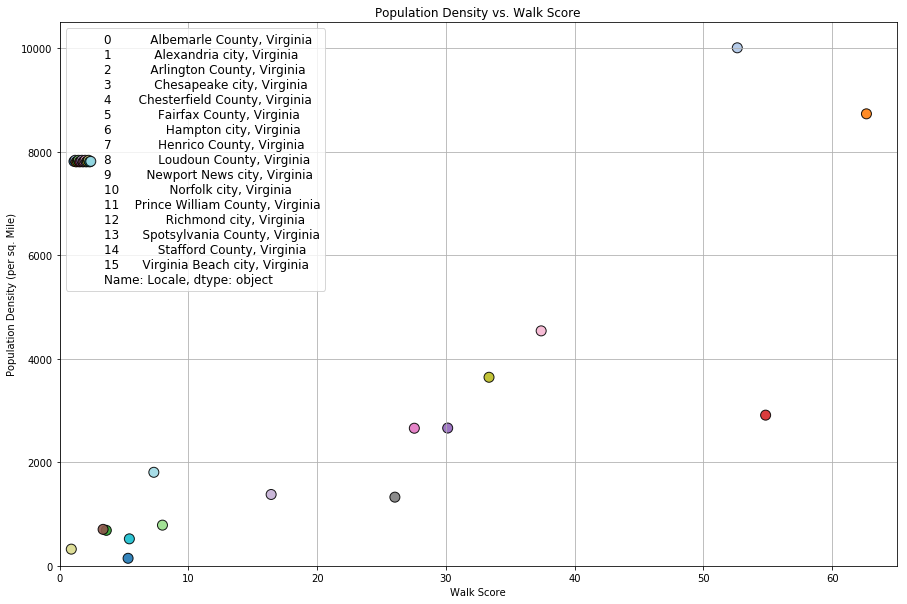

In [18]:
# Build scatter plot population density vs. walk score
fig, ax = plt.subplots(figsize=(15, 10))

colors = plt.cm.tab20(np.linspace(0, 1, len(final_df['Locale'])))


ax.scatter(final_df['Walk Score'], round(final_df['Population Density'].astype(float), 2),
           edgecolor="k", linewidths=1, marker="o", s=100, label=final_df['Locale'],
           c=colors, alpha=0.9)

# format graph 
plt.grid()
plt.xlim([0, 65])
plt.ylim([0, 10500])

plt.xlabel('Walk Score')
plt.ylabel('Population Density (per sq. Mile)')
plt.title('Population Density vs. Walk Score')
plt.legend(loc=2, fontsize=12, markerfirst=True, scatterpoints=16,)

# save figure
#plt.savefig("popdens_v_walkscore.png")

# show plot
plt.show()

In [19]:
labels = list(final_df['Locale'])
labels

['Albemarle County, Virginia',
 'Alexandria city, Virginia',
 'Arlington County, Virginia',
 'Chesapeake city, Virginia',
 'Chesterfield County, Virginia',
 'Fairfax County, Virginia',
 'Hampton city, Virginia',
 'Henrico County, Virginia',
 'Loudoun County, Virginia',
 'Newport News city, Virginia',
 'Norfolk city, Virginia',
 'Prince William County, Virginia',
 'Richmond city, Virginia',
 'Spotsylvania County, Virginia',
 'Stafford County, Virginia',
 'Virginia Beach city, Virginia']

In [20]:
# Calculate correlation
scipy.stats.spearmanr(final_df['Walk Score'], final_df['Population Density'])

C:\Users\brbal\AppData\Local\conda\conda\envs\PythonData\lib\site-packages\scipy\stats\stats.py:253: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


SpearmanrResult(correlation=-0.10882352941176471, pvalue=0.68828829395741398)

In [21]:
scipy.stats.linregress(final_df['Walk Score'], final_df['Population Density'].astype(float))

LinregressResult(slope=121.73691488114747, intercept=-177.33355762064321, rvalue=0.852970078387985, pvalue=2.6756061892615611e-05, stderr=19.909554532284254)

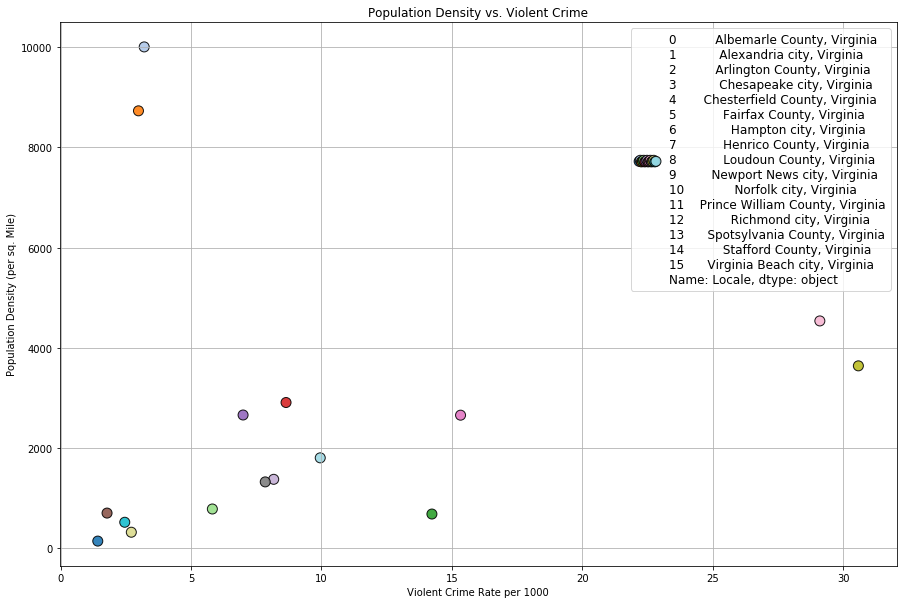

In [28]:
# Build scatter plot population density vs. Violent Crime Rate
fig, ax = plt.subplots(figsize=(15, 10))

colors = plt.cm.tab20(np.linspace(0, 1, len(final_df['Locale'])))


ax.scatter((final_df['Violent Rate']*1000), round(final_df['Population Density'].astype(float), 2),
           edgecolor="k", linewidths=1, marker="o", s=100, label=final_df['Locale'],
           c=colors, alpha=0.9)

# format graph 
plt.grid()
#plt.xlim([0, 65])
#plt.ylim([0, 10500])

plt.xlabel('Violent Crime Rate per 1000')
plt.ylabel('Population Density (per sq. Mile)')
plt.title('Population Density vs. Violent Crime')
plt.legend(loc='best', fontsize=12, markerfirst=True, scatterpoints=16,)

# save figure
#plt.savefig("temp_lat.png")

# show plot
plt.show()

In [22]:
scipy.stats.linregress(final_df['Violent Rate'], final_df['Population Density'].astype(float))

LinregressResult(slope=32090.055835537336, intercept=2372.4878331873479, rvalue=0.099124223149095303, pvalue=0.71493567082516574, stderr=86095.90640790762)

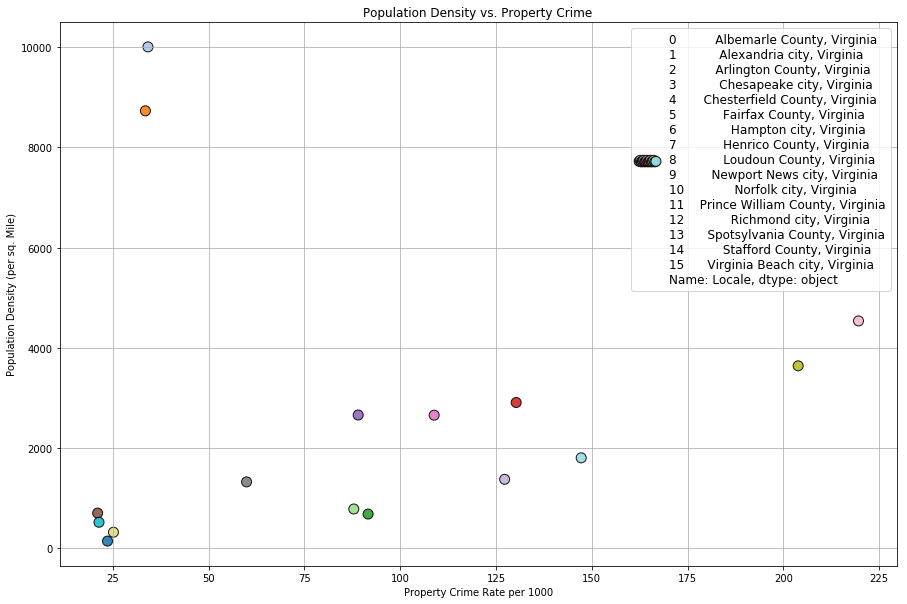

In [29]:
# Build scatter plot population density vs. Property Crime Rate
fig, ax = plt.subplots(figsize=(15, 10))

colors = plt.cm.tab20(np.linspace(0, 1, len(final_df['Locale'])))


ax.scatter((final_df['Property Rate']*1000), round(final_df['Population Density'].astype(float), 2),
           edgecolor="k", linewidths=1, marker="o", s=100, label=final_df['Locale'],
           c=colors, alpha=0.9)

# format graph 
plt.grid()
#plt.xlim([0, 65])
#plt.ylim([0, 10500])

plt.xlabel('Property Crime Rate per 1000')
plt.ylabel('Population Density (per sq. Mile)')
plt.title('Population Density vs. Property Crime')
plt.legend(loc='best', fontsize=12, markerfirst=True, scatterpoints=16,)

# save figure
#plt.savefig("temp_lat.png")

# show plot
plt.show()

In [23]:
scipy.stats.linregress(final_df['Property Rate'], final_df['Population Density'].astype(float))

LinregressResult(slope=2542.8917908120338, intercept=2449.5005134653484, rvalue=0.056021346028578049, pvalue=0.83673720508054705, stderr=12112.33176310721)